<a href="https://colab.research.google.com/github/Euxen/OCRwYolov8/blob/main/ANPR_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install easyocr
!pip install imutils
!pip install ultralytics==8.0.196
!pip install roboflow --quiet
!pip install supervision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.2 MB/s eta 0:00:00


After installing our building blocks, now we can start coding out the application.

In [7]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr
from PIL import Image


CV2 is our Image Reader. <br>
Matplotlib/Numpy is to help out with anything math-related and graphs. <br>
Imutils to help grab the mask/countours <br>
EasyOCR to help read from image and convert to text<br>

New Edit (Yolov8 trained model)
Here we will introduce and train a YoloV8 model with the help of a database from roboflow.

Establishing a variable to hold the root source location. Makes it reusable and easier to make dynamic pathings later on.

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [6]:
!nvidia-smi

Wed Mar 13 04:00:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Installing the important dependencies to make this work.

In [4]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/201.2 GB disk)


Downloading the Number Plate database from roboflow.

In [12]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets


from roboflow import Roboflow
rf = Roboflow(api_key="jADKDNfFIwo7Mpe370mV")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-4 in yolov8:: 100%|██████████| 48488/48488 [00:13<00:00, 3609.93it/s]


Training the model with the data inside the database

In [15]:
import os

# Assuming dataset.location contains the path to the dataset
best_weight_path = r"{HOME}/runs/detect/train/weights/best.pt"

if not os.path.exists(best_weight_path):
    # Run training only if the best.pt file doesn't exist
    %cd {HOME}
    !yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=5 imgsz=800 plots=True
else:
    print("Best weight file already exists. Skipping training.")


/content
New https://pypi.org/project/ultralytics/8.1.27 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/License-Plate-Recognition-4/data.yaml, epochs=5, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None

After training, we need to validate that the model we trained is able to know and use what it learned.

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/License-Plate-Recognition-4/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100% 2046/2046 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 128/128 [00:40<00:00,  3.15it/s]
                   all       2046       2132      0.966      0.929      0.967      0.639
Speed: 0.6ms preprocess, 13.3ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


Now we look at the results.....

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					     PR_curve.png	    val_batch0_pred.jpg
confusion_matrix_normalized.png			     R_curve.png	    val_batch1_labels.jpg
confusion_matrix.png				     results.csv	    val_batch1_pred.jpg
events.out.tfevents.1710181909.d74b3b3c4c16.10872.0  results.png	    val_batch2_labels.jpg
F1_curve.png					     train_batch0.jpg	    val_batch2_pred.jpg
labels_correlogram.jpg				     train_batch1.jpg	    weights
labels.jpg					     train_batch2.jpg
P_curve.png					     val_batch0_labels.jpg


/content


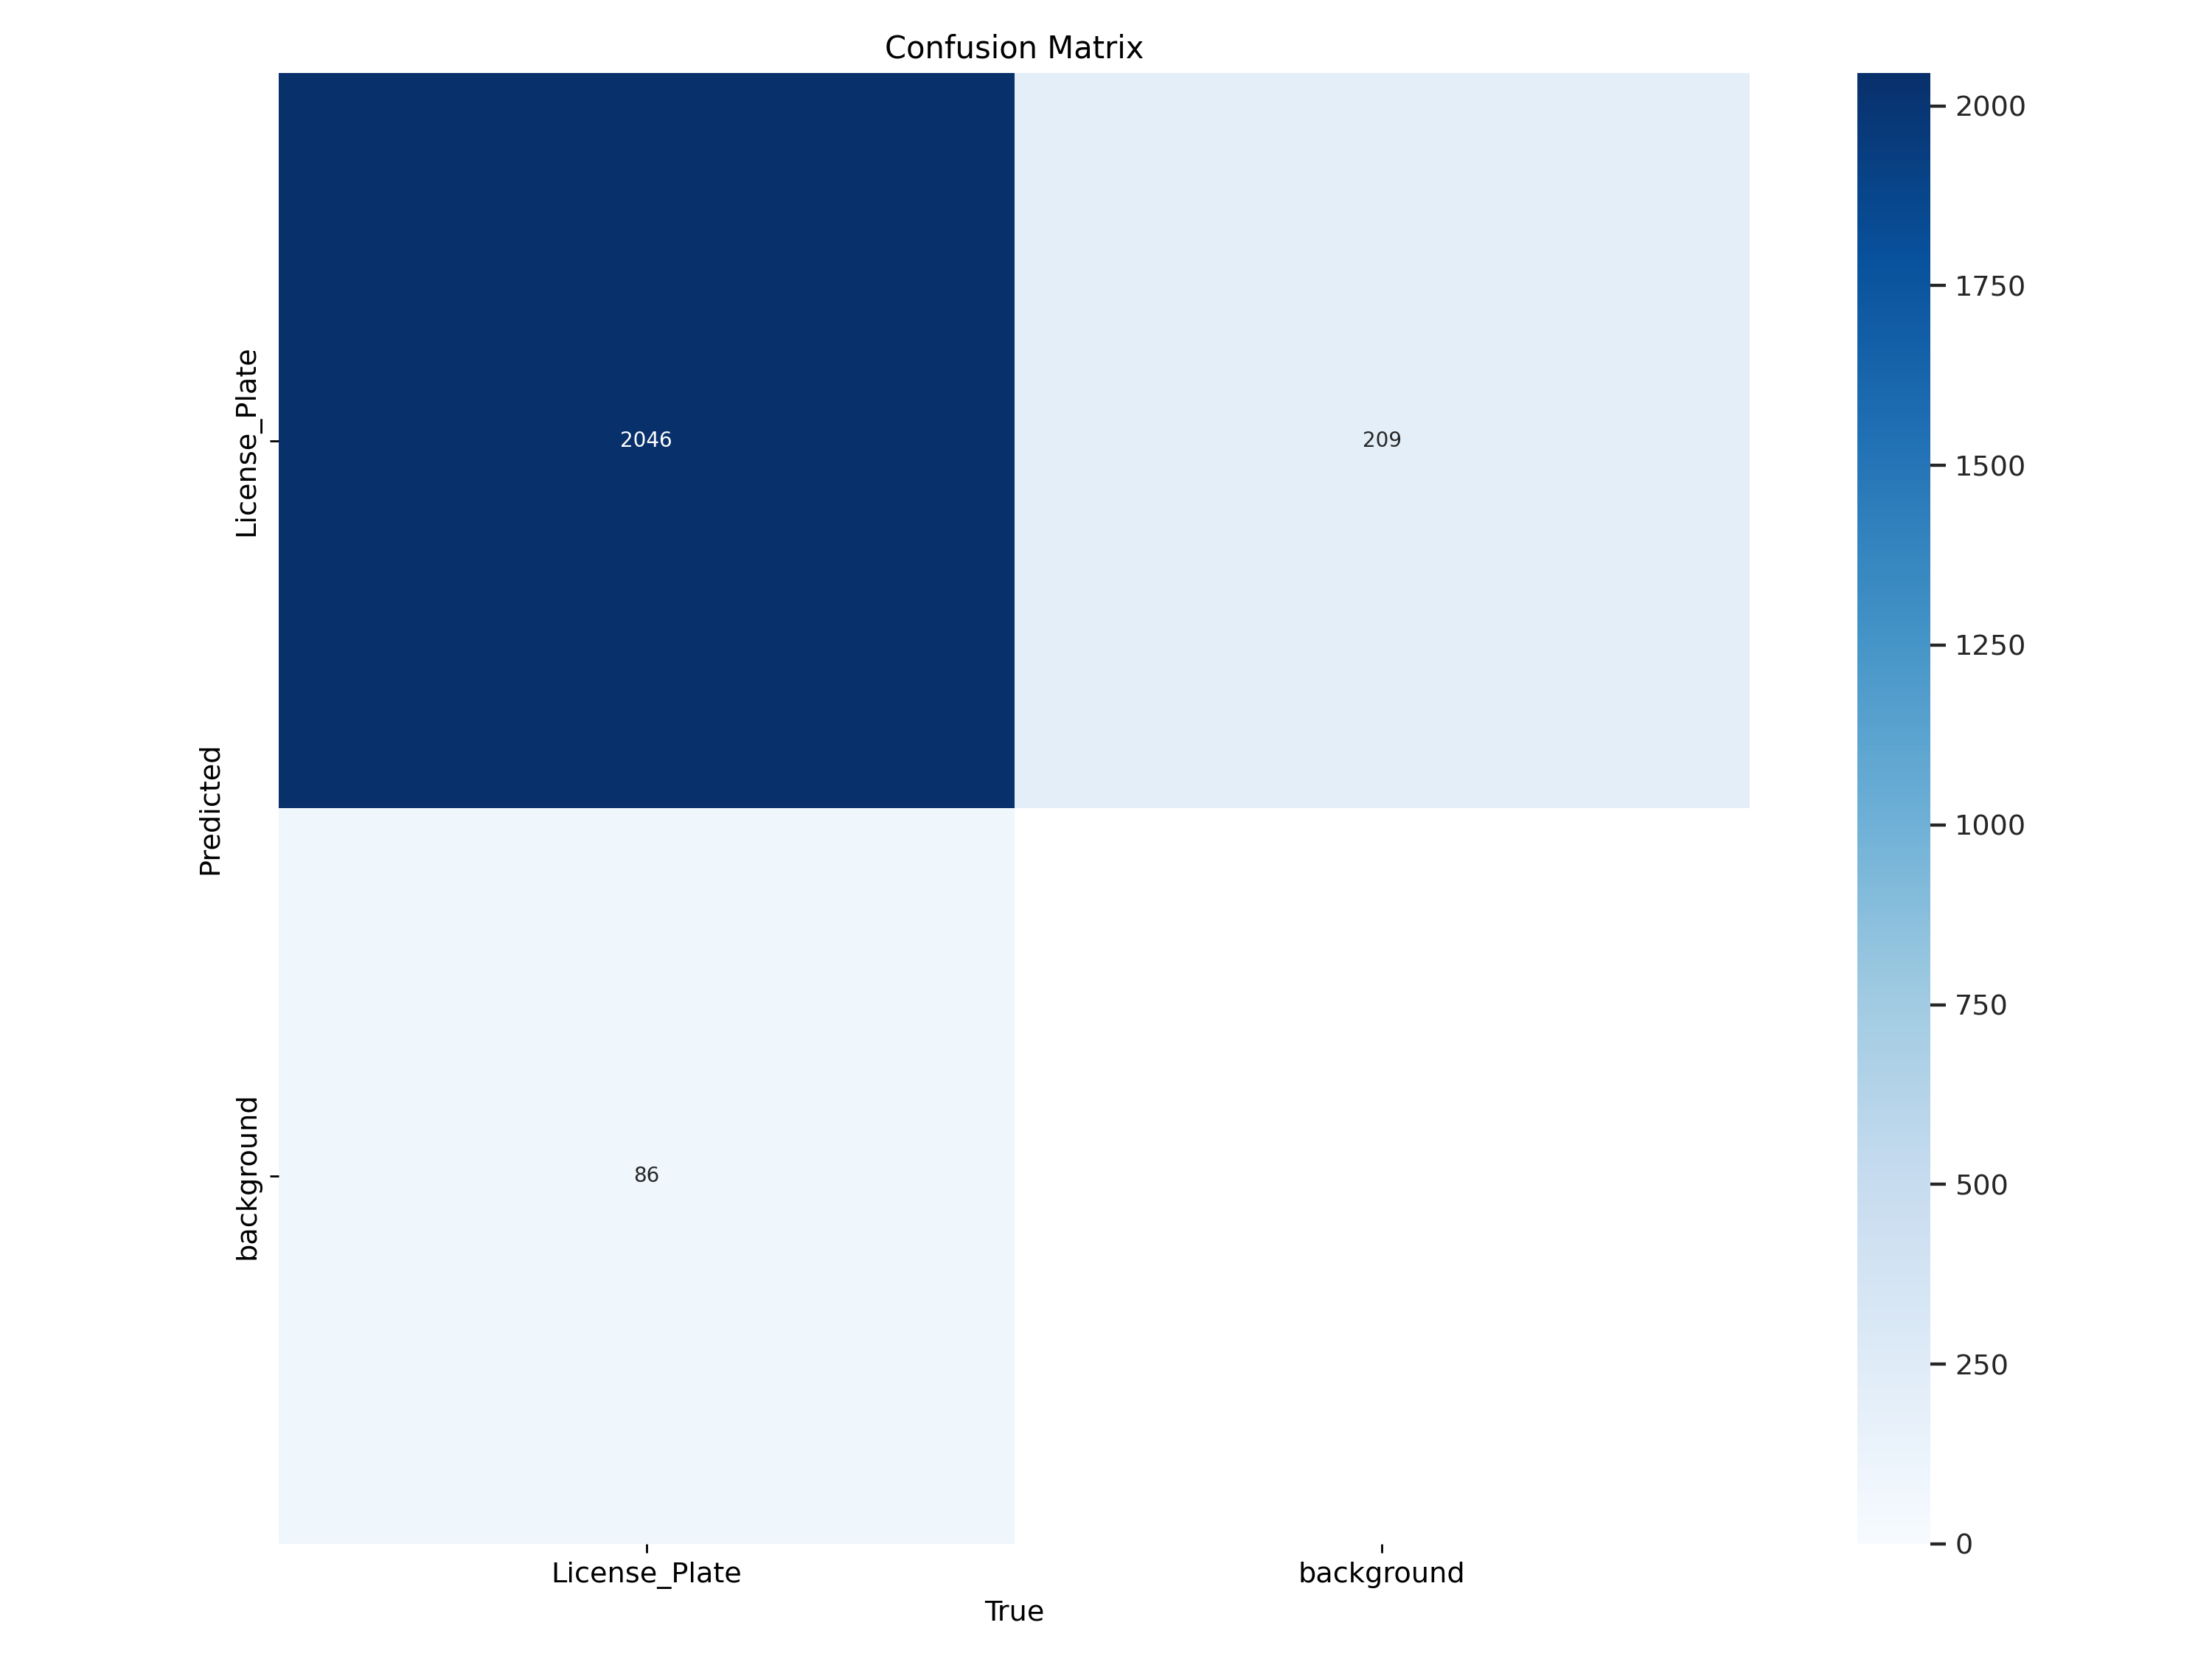

In [ ]:
%cd {HOME}
Image.open(f'{HOME}/runs/detect/train/confusion_matrix.png')

/content


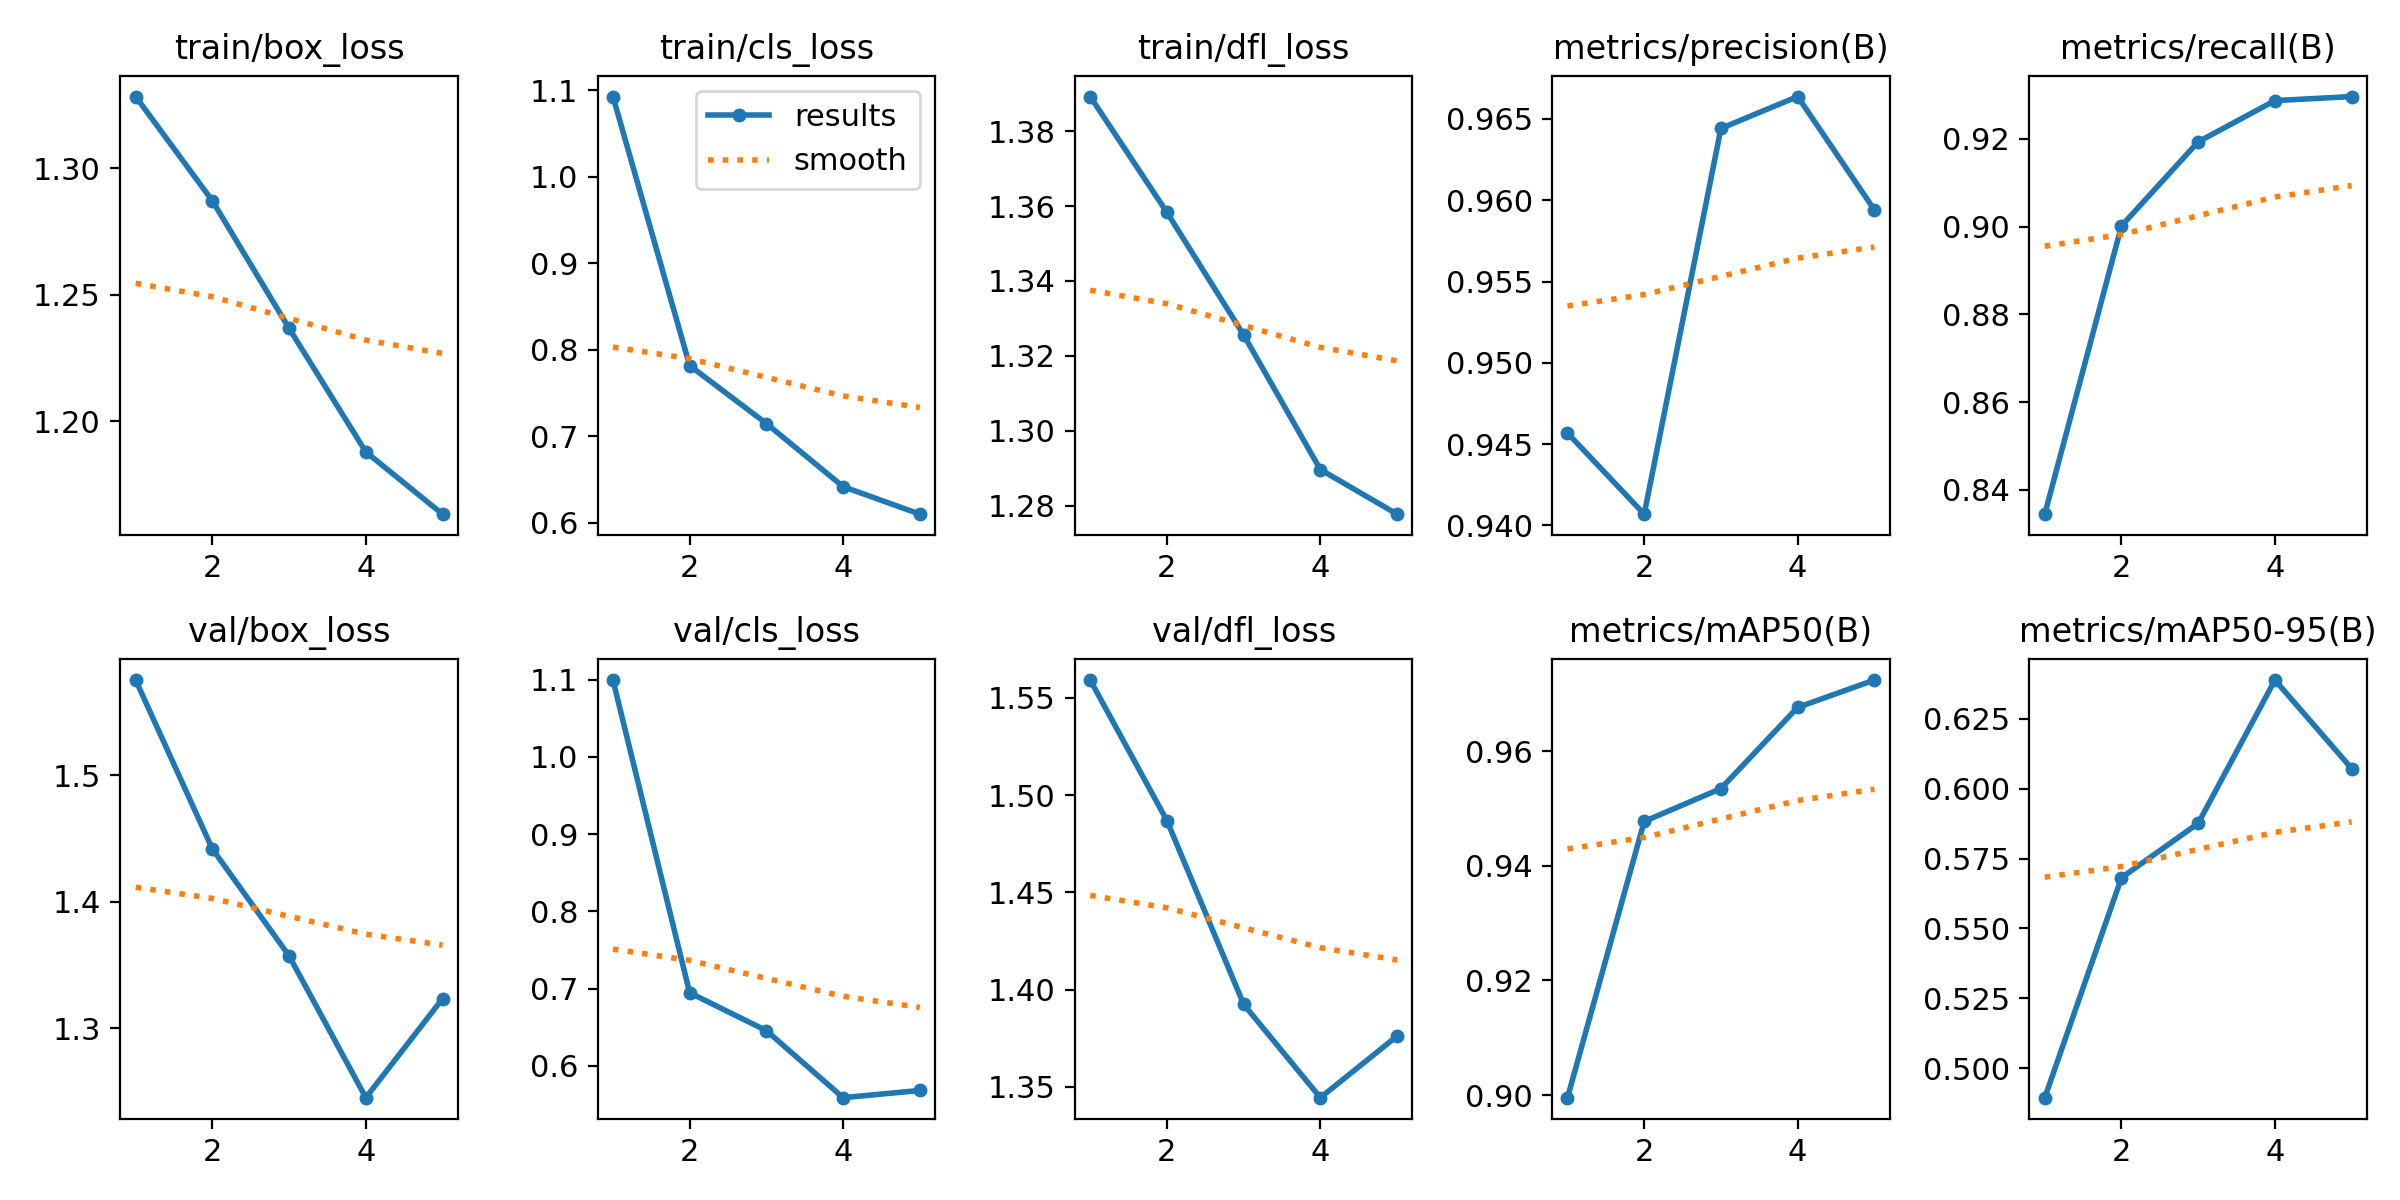

In [ ]:
%cd {HOME}
Image.open(f'{HOME}/runs/detect/train/results.png')

/content


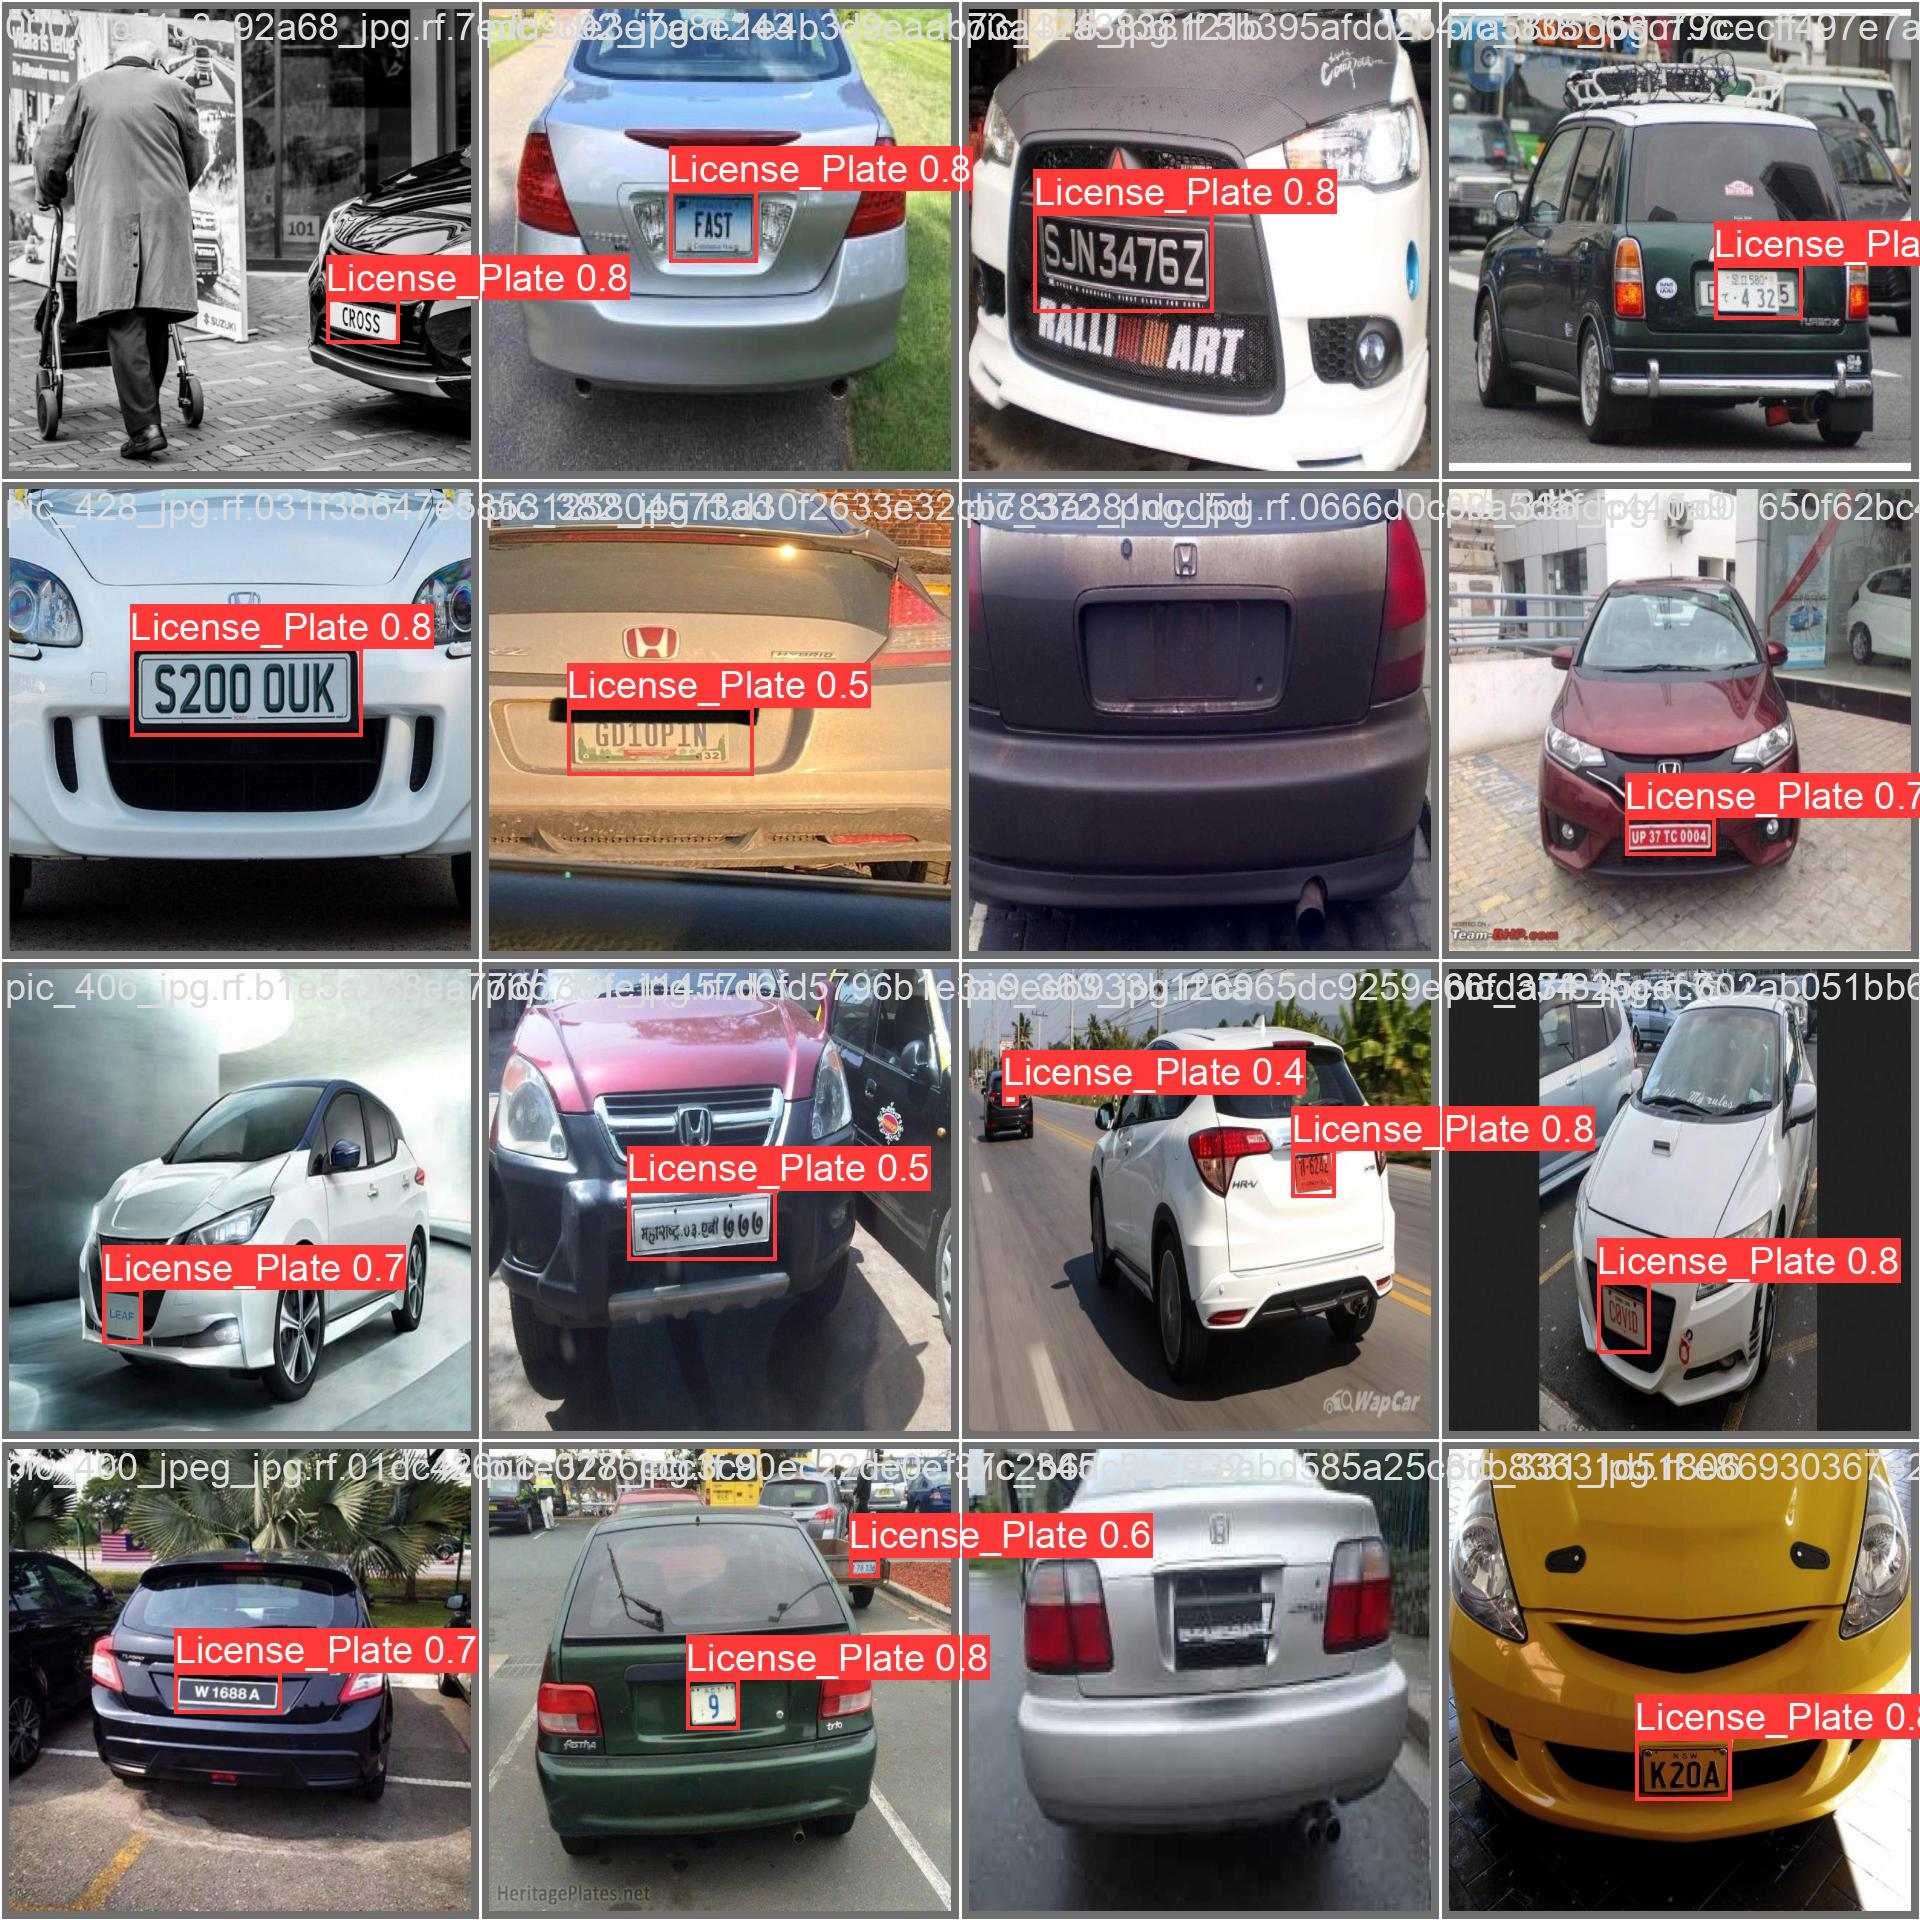

In [ ]:
%cd {HOME}
Image.open(f'{HOME}/runs/detect/train/val_batch0_pred.jpg')

Now we test the results of our training and validation..

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Now we integrate it into our OCR code <br> But first, we need to make functions that work with our OCR and Image/File management

In [16]:
# Step 1: Use YOLOv8 for number plate detection
# Your YOLOv8 detection code here

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_number_plates(image):
    # YOLOv8 detection model
    %cd {HOME}
    model = YOLO(f'{HOME}/best.pt')
    results = model.predict(image)

    # List to store the coordinates of the predicted number plates
    plate_coordinates = []

    # Process each detected object
    for box in results[0].boxes:
        class_id = results[0].names[box.cls[0].item()]
        coords = box.xyxy[0].tolist()
        coords = [round(x) for x in coords]
        conf = round(box.conf[0].item(), 2)
        print("Object type:", class_id)
        print("Coordinates:", coords)
        print("Probability:", conf)
        print("---")

        # Append coordinates to the list
        plate_coordinates.append(coords)

    return plate_coordinates


In [17]:
# Step 2: Use EasyOCR for plate reading directly on the detected regions
def read_plate(cropped_region):
    reader = easyocr.Reader(['en'])
    results = reader.readtext(cropped_region)
    if results:
        return results[0][-2]  # Extracting recognized text
    else:
        return None

# Detect number plates using YOLOv8
cropped_regions = detect_number_plates(image)

# Read text from detected number plates using EasyOCR
for region in cropped_regions:
    plate_text = read_plate(region)
    if plate_text:
        print("Detected Plate Text:", plate_text)
    else:
        print("No text detected on the plate.")


'\n# Detect number plates using YOLOv8\ncropped_regions = detect_number_plates(image)\n\n# Read text from detected number plates using EasyOCR\nfor region in cropped_regions:\n    plate_text = read_plate(region)\n    if plate_text:\n        print("Detected Plate Text:", plate_text)\n    else:\n        print("No text detected on the plate.")\n'

1. Read the Image, and then classify it

In [20]:
# Load the image

import supervision as sv
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

coordinates = detect_number_plates(f'/{HOME}/VW-Tiguan-Allspace-SEL-2018-17.jpg')
print (coordinates)


# Now that we have the coordinates of the "potential" license plate, we can now crop it
# From there, we extract the text, treat it, and output it

text = read_plate(f'/{HOME}/VW-Tiguan-Allspace-SEL-2018-17.jpg')
print (text)


/content



image 1/1 //content/VW-Tiguan-Allspace-SEL-2018-17.jpg: 448x640 1 LicensePlate, 18.1ms
Speed: 3.6ms preprocess, 18.1ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


Object type: LicensePlate
Coordinates: [1343, 720, 1530, 785]
Probability: 0.77
---
[[1343, 720, 1530, 785]]
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteTIguan
